# scRNA-seq Imputation

Data Availability Statement
Tabula Muris data

Smart-seq2 https://doi.org/10.6084/m9.figshare.5715040.v1 ( Consortium, The Tabula Muris, 2017a).

10X Chromium https://doi.org/10.6084/m9.figshare.5715040.v1 ( Consortium, The Tabula Muris, 2017b).

R packages

MAGIC: Rmagic (v0.1.0) https://github.com/KrishnaswamyLab/MAGIC

DrImpute: DrImpute (v1.0) https://github.com/ikwak2/DrImpute

scImpute: scImpute(v0.0.8) https://github.com/Vivianstats/scImpute

SAVER: SAVER(v1.0.0) https://github.com/mohuangx/SAVER

Knn-smooth: knn_smooth.R (Version 2) https://github.com/yanailab/knn-smoothing

Scater: scater(v1.6.3) : https://www.bioconductor.org/packages/release/bioc/html/scater.html

Splatter: splatter(v1.2.2) : https://bioconductor.org/packages/release/bioc/html/splatter.html

Permute: permute(v0.9-4) : https://cran.r-project.org/web/packages/permute/index.html

Python/anaconda packages:

Dca : dca(v0.2.2): https://github.com/theislab/dca

Custom scripts: https://github.com/tallulandrews/F1000Imputation

In [2]:
import os
import pandas as pd
import numpy as np
import h5py
import scipy as sp
import scanpy as sc

## Denoising scRNA-seq Data with DCA

In [ ]:
# file_path =  '/data/endoderm/endoderm.csv'
# endoderm = pd.read_csv(file_path, index_col=0)
# endoderm.head()

### 1. Running the dca package on definite endoderm cells (DECs)

The single cell expression data of DECs are obtained from the GEO website (https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE75748). The dataset includes the RNA expression count data of 1018 single cells from snapshot progenitors.

The paper for analysis of the dataset: Single-cell RNA-seq reveals novel regulators of human embryonic stem cell differentiation to definitive endoderm. https://pubmed.ncbi.nlm.nih.gov/27534536/

In [ ]:
# !python -m dca.__main__ data/endoderm/endoderm.csv data/endoderm/results/

In [58]:
end_label = [label.split("_")[0] for label in endoderm.index.to_list()]

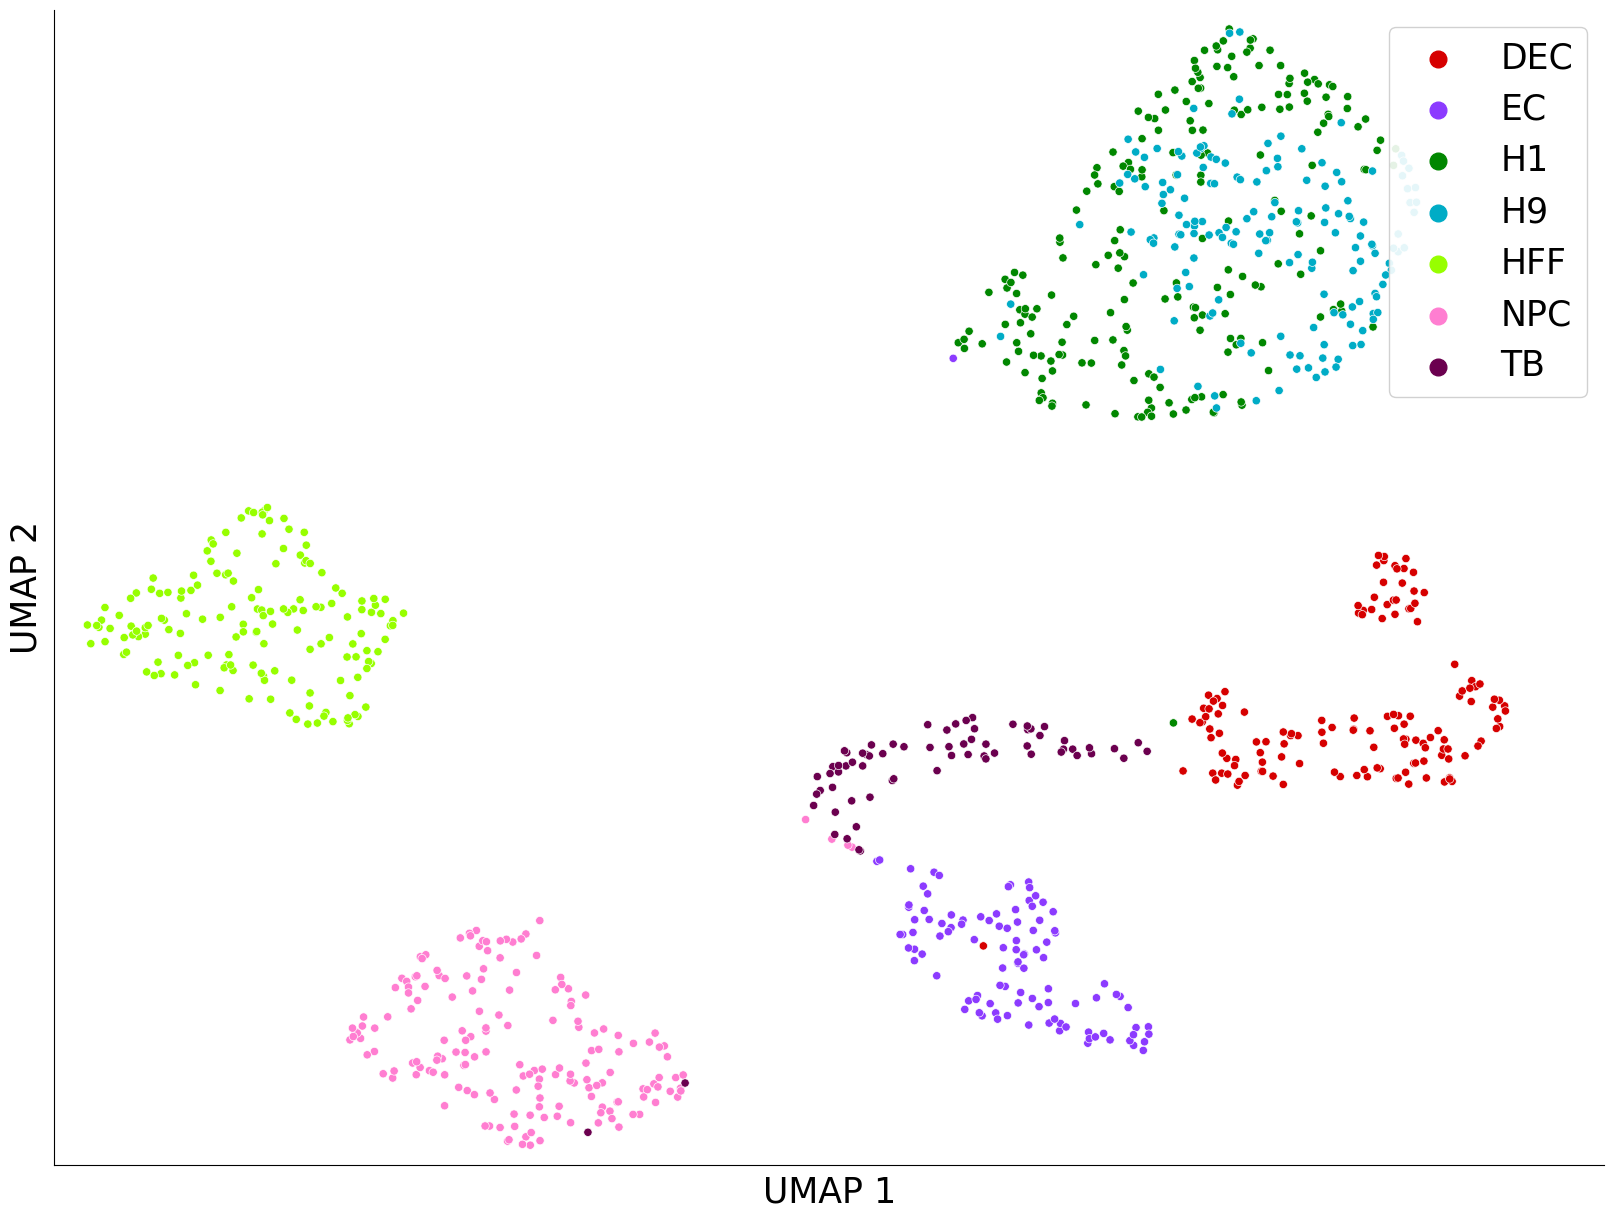

In [59]:
# endoderm_dn_dca = pd.read_csv('data/endoderm/mean.tsv', sep='\t', index_col=0)
# endoderm_dn_dca = endoderm_dn_dca.T

# end_dca_emb = get_embedding(endoderm_dn_dca)
# end_dca_emb
draw_umap(end_dca_emb, end_label)

"The tight clusters of overlapped H1 and H9 single cells indicated the relative homogeneity of human ES cells compared to the rest of the progenitors" 

-- Chu et al. (2016)

In [ ]:
from keras.layers import Dense, Input
from keras.models import Model
from dca.layers import ColwiseMultLayer


def build(adata, hid_size):
    input_size = adata.n_vars
    output_size = input_size
    hid_size = hid_size
    extra_models = {}

    input_layer = Input(shape=(input_size,), name='count')
    sf_layer = Input(shape=(1,), name='size_factors')

    decoder_output = Dense(hid_size, activation=None, name='center')(input_layer)
    mean = Dense(output_size, name='mean')(decoder_output)
    output = ColwiseMultLayer([mean, sf_layer])

    extra_models['mean_norm'] = Model(inputs=input_layer, outputs=mean)
    extra_models['decoded'] = Model(inputs=input_layer, outputs=decoder_output)
    
    model = Model(inputs=[input_layer, sf_layer], outputs=output)
 
    encoder = Model(inputs=model.input,
                    outputs=model.get_layer('center').output)


    print('dca: Calculating low dimensional representations...')

    adata.obsm['X_dca'] = encoder.predict({'count': adata.X,
                                           'size_factors': adata.obs.size_factors})        
    print('dca: Calculating reconstructions...')

    adata.X = model.predict({'count': adata.X,
                             'size_factors': adata.obs.size_factors})
    
    return adata

adata = build(adata)

## scDMFK

In [60]:
!python scDMFK/run.py --dataname "endoderm/endoderm.csv" --outputdir "endoderm/results/" --transpose True --pretrain_epoch 500

2024-04-13 23:40:42.211929: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
Instructions for updating:
non-resource variables are not supported in the long term
begin training
Successfully preprocessed 1018 cells and 19097 genes
begin the pretraining
2024-04-13 23:41:19.047111: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 23:41:19.145721: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2024-04-13 23:41:19.805294: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such

In [3]:
import scDMFK.utils as utils
from scDMFK.preprocess import *

In [32]:
## Endoderm dataset

# adata = prepro('endoderm/endoderm.csv')
# adata = adata.transpose()

# adata = normalize(adata, highly_genes=500, size_factors=True, normalize_input=True, logtrans_input=True)
adata.obs

,n_counts,size_factors
H1_Exp1.001,1494450.0,0.339551
H1_Exp1.002,2169089.0,0.492834
H1_Exp1.003,1727355.0,0.392469
H1_Exp1.004,1391420.0,0.316142
H1_Exp1.006,1419963.0,0.322627
...,...,...
TB_Batch2.140,3975507.0,0.903267
TB_Batch2.141,3979547.0,0.904185
TB_Batch2.142,6002437.0,1.363801
TB_Batch2.143,5583433.0,1.268600


In [8]:
## Young dataset
# adata = prepro('Young/data.h5')
# (adata.X != 0).any(axis=0)

### Clustering with UMAP

In [4]:
# import colorcet as cc
# import umap
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.manifold import TSNE
# from sklearn.preprocessing import StandardScaler
from scDMFK.io import get_embedding, draw_umap

/home/dengyf2000/.pyenv/versions/3.8.18/envs/sc-env/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-04-13 21:56:03.199879: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [5]:
# endoderm = pd.read_csv('data/endoderm/endoderm.csv', index_col=0)
# endoderm = endoderm.T
endoderm

,MKL2,CD109,ABTB1,MAST2,KAT5,WWC2,CD163,MYL2,UBE2Z,RGPD4,...,SNRNP48,ARMC3,DUSP28,INO80,NUP205,WDR33,EPSTI1,CLPTM1L,CCDC125,CATSPER3
H1_Exp1.001,10,6,0,0,0,84,0,0,18,0,...,84,0,0,0,239,101,0,22,32,0
H1_Exp1.002,162,2,28,133,7,5,0,0,146,4,...,40,0,0,187,231,201,0,84,52,0
H1_Exp1.003,3,166,0,41,52,305,0,0,106,0,...,21,0,0,6,169,23,0,19,110,0
H1_Exp1.004,42,9,1,0,20,41,0,0,9,0,...,12,0,0,49,90,164,0,52,73,1
H1_Exp1.006,0,7,0,0,0,142,0,0,14,5,...,41,0,0,26,240,181,0,2,53,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,5,23,0,206,0,46,0,0,74,0,...,185,0,0,7,0,5,146,0,221,0
TB_Batch2.141,500,362,0,43,56,90,0,0,15,0,...,156,0,0,0,251,79,539,296,166,0
TB_Batch2.142,18,22,3,2,2,562,0,0,25,0,...,10,0,0,28,0,6,0,0,131,0
TB_Batch2.143,472,36,39,1,0,778,0,0,225,2,...,719,0,0,211,2,124,21,271,730,0


In [61]:
endoderm_dn = pd.read_csv('data/endoderm/results/mean-dmfk.csv', index_col=0)
endoderm_dn

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
H1_Exp1.001,2.401728,3.091926,-2.835459,-14.677802,-9.676631,-7.127669,-5.392970,14.003097,4.636516,2.711749,...,13.572371,-7.340757,7.222789,-11.989021,2.434686,-6.901189,-4.491098,-6.903553,-1.386456,-6.705880
H1_Exp1.002,1.677361,3.076988,-3.392291,-15.207031,-10.002911,-7.127074,-4.664378,15.043894,4.602315,3.227126,...,13.213706,-8.117429,7.373246,-12.601778,2.503209,-6.744094,-7.240670,-5.907737,-1.014718,-7.331488
H1_Exp1.003,3.004116,3.749178,-2.214871,-13.760024,-10.446985,-6.274363,-5.027885,11.821609,4.216933,2.641542,...,12.157099,-6.925454,5.870554,-10.984313,1.919802,-6.638227,-5.744042,-5.891906,-0.937249,-6.416768
H1_Exp1.004,2.206557,2.424457,-1.909186,-12.454841,-7.612658,-7.355981,-4.905523,10.819155,4.078805,2.648014,...,11.926175,-5.126273,5.958485,-10.497061,2.548305,-5.039920,-4.384023,-5.849918,-1.021263,-4.152729
H1_Exp1.006,1.717558,2.594968,-3.269201,-15.161434,-9.553669,-7.714719,-6.047932,13.658421,5.054265,3.412324,...,13.104202,-7.870401,6.563110,-11.411247,1.980160,-6.996863,-6.124058,-7.295327,-1.697270,-6.348874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,4.469290,-2.804128,2.737004,0.878658,1.363911,-10.145500,3.364032,3.721085,2.050262,2.160548,...,12.712300,-7.180542,7.917675,-13.143593,6.656322,0.854017,-3.320709,-0.876745,0.847250,-1.222535
TB_Batch2.141,5.117177,-3.218228,5.484375,-2.031740,-1.329534,-12.980489,7.995451,4.752485,5.553689,1.768812,...,15.587984,-10.401495,7.341401,-12.821471,8.035480,1.640577,-7.995227,-2.721292,1.871282,-0.612714
TB_Batch2.142,4.419330,-3.454971,3.645096,2.245051,1.166885,-13.338704,5.516618,4.128413,2.085917,4.015101,...,13.787154,-10.297188,9.624862,-16.151260,6.635363,-0.004298,-6.571407,-0.483705,0.119021,-1.440258
TB_Batch2.143,5.285388,-2.769946,3.287274,1.453055,1.387361,-12.451121,4.801982,3.231471,1.869505,3.622995,...,12.845781,-7.872955,8.959832,-14.620464,6.269373,0.836513,-4.724019,-1.559451,1.383966,-0.790937


/home/dengyf2000/.pyenv/versions/3.8.18/envs/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


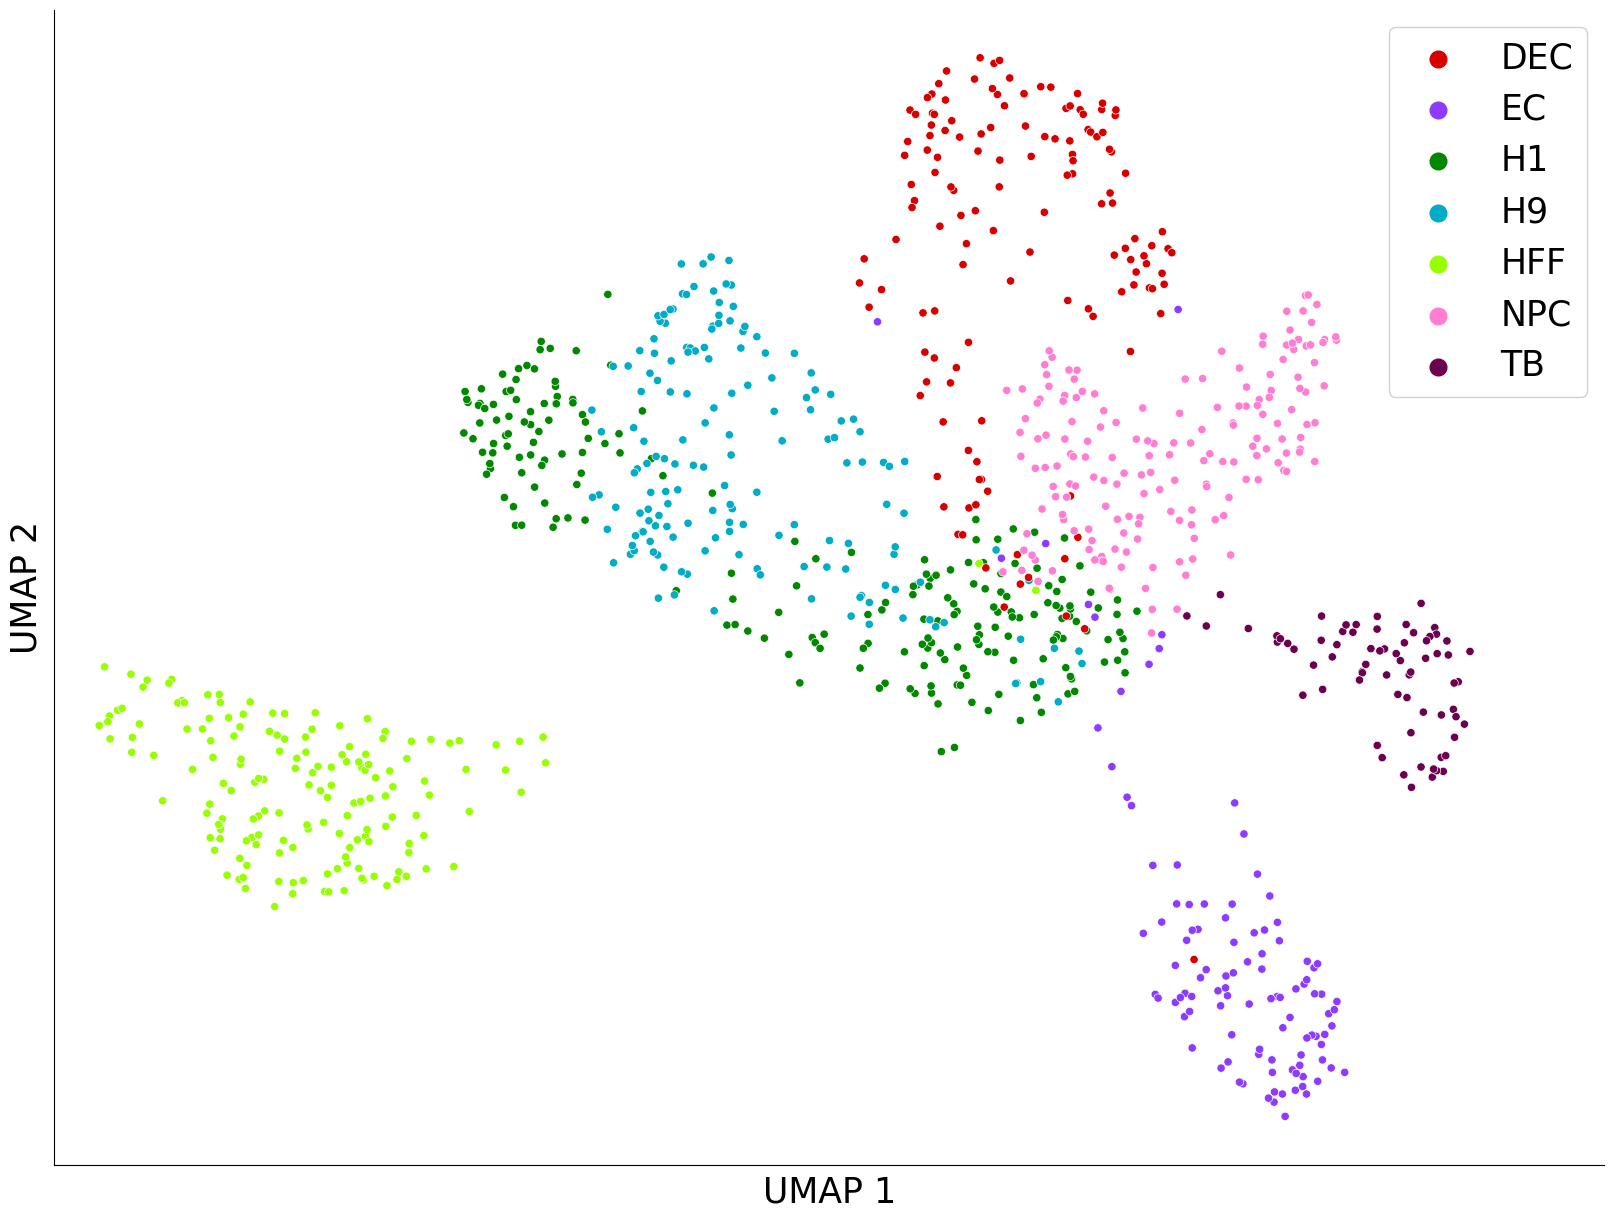

In [7]:
np.random.seed(1111)
end_embedding = get_embedding(endoderm.values)
draw_umap(end_embedding, label)

In [38]:
endoderm_dn

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
H1_Exp1.001,-0.608840,-0.037075,0.292084,0.508117,0.189628,0.674831,-0.424202,-0.014046,0.345151,0.099027,...,-0.088865,0.603149,-0.274001,0.241632,0.220028,0.245932,0.508371,1.758681,0.338010,0.432860
H1_Exp1.002,0.009865,-0.276497,0.437671,1.103121,0.776358,0.389517,0.245108,-0.083143,-0.838327,-0.206783,...,-0.096169,1.102352,-0.281576,-0.273777,-0.168029,0.798531,0.648802,1.597688,0.272574,0.193437
H1_Exp1.003,0.396579,0.198962,0.291666,0.738301,0.138301,0.984834,-0.606224,-0.745645,-0.175007,-1.116832,...,0.858881,1.096777,-0.035296,-0.363887,0.107283,1.937861,0.750079,2.436431,0.036168,0.488764
H1_Exp1.004,0.520587,-0.347691,0.799633,0.626188,0.382404,0.860936,0.574070,-0.064868,-0.389710,-0.439063,...,-0.445698,-0.495501,-0.739247,-0.965476,-0.639044,0.528894,0.516317,0.829474,-0.169163,-0.095225
H1_Exp1.006,-0.586558,-0.317091,1.776587,0.560432,-0.420569,1.236424,-0.626272,-0.173435,0.083725,-0.785912,...,0.036792,0.284981,0.673449,-0.698382,0.674026,0.777840,0.310186,2.075025,0.168625,0.763679
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TB_Batch2.140,1.121176,0.449058,0.814575,1.440805,1.442142,0.367947,0.196573,-0.141140,-0.128131,-0.911918,...,-0.176062,-0.020949,-1.457506,0.048426,0.557861,0.621742,1.564356,1.706149,-0.162530,0.673285
TB_Batch2.141,0.860942,-0.858325,-0.424606,3.689307,1.683996,2.386303,0.570336,-0.721699,1.985925,0.474756,...,1.788981,-1.490360,-5.170162,1.426545,0.418896,-0.028611,1.183485,2.400591,0.034172,4.674096
TB_Batch2.142,0.552046,0.084669,0.340960,1.772087,2.312814,0.385664,0.048536,-0.374155,0.374388,-0.604941,...,1.030392,-0.350768,-1.013161,0.669864,0.380158,1.177414,1.404268,1.844552,-0.496609,2.061590
TB_Batch2.143,0.756474,-0.463118,0.306096,1.268463,1.806868,0.173297,0.568933,-0.116080,-0.252415,-0.347074,...,0.031357,-0.157453,-0.641329,0.024130,-0.319190,0.919284,0.631308,1.594385,-0.432054,1.401622


/home/dengyf2000/.pyenv/versions/3.8.18/envs/sc-env/lib/python3.8/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


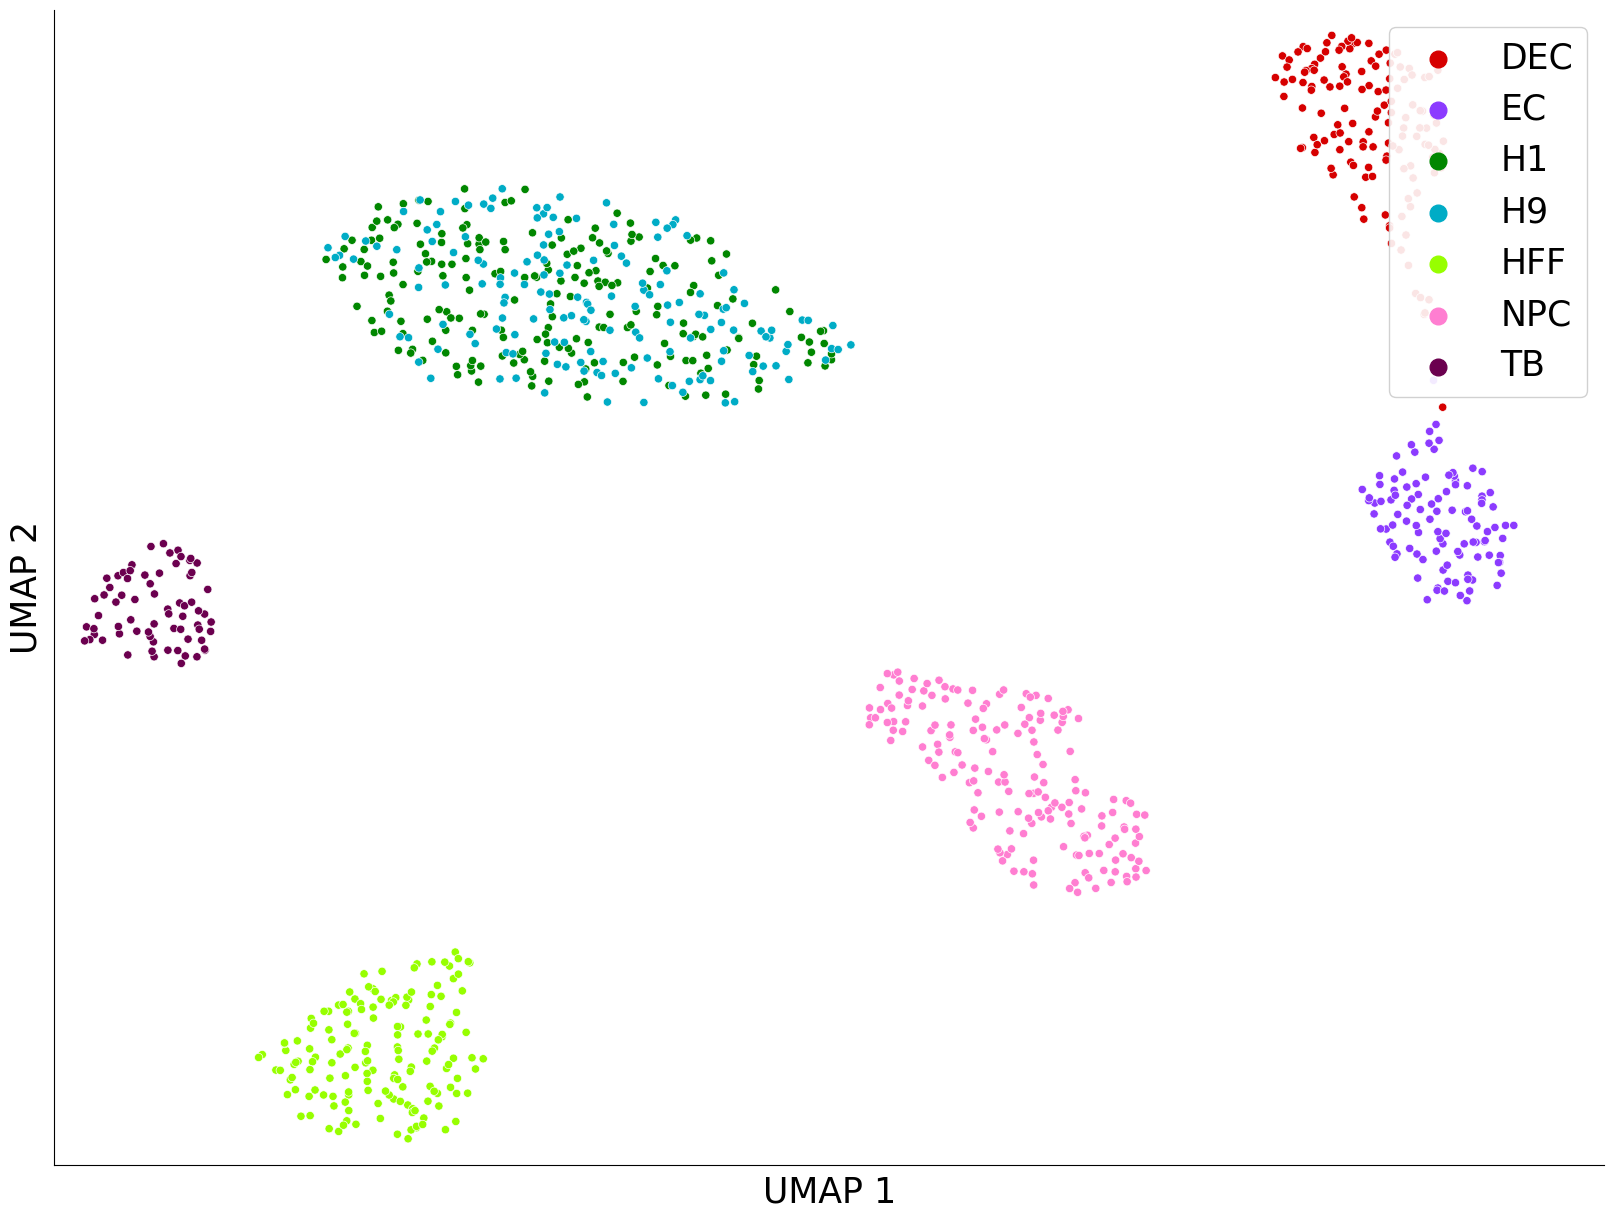

In [62]:
np.random.seed(2222)
end_scdm_embedding = get_embedding(endoderm_dn.values)
draw_umap(end_scdm_embedding, label)